## 1.데이터로드전처리

In [27]:
import itertools
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
file_path = './dataset/'
train_fn = 'FordA_TRAIN.arff'
test_fn = 'FordA_TEST.arff'

def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])

    for i, col in zip(range(len(cols)), cols):
        data2d[:, i]=raw_data[col]
    return data2d

train =  read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

In [3]:
print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [4]:
x_train_temp = train[:,:-1]
y_train_temp = train[:,-1]

x_test = test[:, :-1]
y_test = test[:, -1]

In [5]:
normal_x = x_train_temp[y_train_temp==1]
abnormal_x = x_train_temp[y_train_temp==-1]
normal_y = y_train_temp[y_train_temp==1]
abnormal_y = y_train_temp[y_train_temp==-1]

x_train_normal, x_valid_normal, y_train_normal, y_valid_normal = train_test_split(
    normal_x, normal_y, test_size=0.2, random_state=42, stratify=normal_y)

x_train_abnormal, x_valid_abnormal, y_train_abnormal, y_valid_abnormal = train_test_split(
    abnormal_x, abnormal_y, test_size=0.2, random_state=42, stratify=abnormal_y)

x_train = np.concatenate((x_train_normal, x_train_abnormal), axis=0)
y_train = np.concatenate((y_train_normal, y_train_abnormal), axis=0)

x_valid = np.concatenate((x_valid_normal, x_valid_abnormal), axis=0)
y_valid = np.concatenate((y_valid_normal, y_valid_abnormal), axis=0)

In [6]:
print('x_train.shape:', x_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_valid.shape:', y_valid.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (2880, 500)
x_valid.shape: (721, 500)
y_train.shape: (2880,)
y_valid.shape: (721,)
x_test.shape: (1320, 500)
y_test.shape: (1320,)


In [7]:
print("x_train shape:", x_train.shape)  # (num_samples, num_features)
print("x_valid shape:", x_valid.shape)  # (num_samples, num_features)

x_train shape: (2880, 500)
x_valid shape: (721, 500)


In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stder = StandardScaler()
stder.fit(x_train)
x_train = stder.transform(x_train)
x_valid = stder.transform(x_valid)

# rscaler = RobustScaler()
# rscaler.fit(x_train)
# x_train = rscaler.transform(x_train)
# x_valid = rscaler.transform(x_valid)

In [9]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

## 3.지표 함수

##### (1) Confustion Matrix

In [10]:
def draw_confusion_matrix(model, xt, yt, model_name):
    y_pred = model.predict(xt)
    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max() / 2
    fmt = 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(classification_report(yt, y_pred))

##### (2) ROC Curve

In [11]:
def draw_roc(model, xt, yt, model_name):
    # numpy로 구현한 모델인 경우
    if not hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_prob(xt)
    else:
        # sklearn 모델인 경우
        y_pred_proba = model.predict_proba(xt)[:, 1]
        
    fpr, tpr, _ = roc_curve(yt, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (3) Epoch에 따른 학습 & 검증의 손실(loss) 그래프


In [12]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.ylabel('loss', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (4) Epoch에 따른 정확도(Accuracy Rate) 그래프

In [13]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val'+'sparse_categorical_accuracy'])
    plt.title('model'+'Prediction Accuracy')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

## 4.모델 구축 및 설계

### 4.1 Logistic Regression

#### 1)로지스틱 회귀 모델 구현 (Numpy)

과정
데이터 전처리:

절편 항 추가:
self.fit_intercept가 True로 설정되어 있으므로, __add_intercept 메서드를 호출하여 **x_train**에 절편 항을 추가합니다.
결과적으로 입력 데이터의 형상이 (샘플 수, 특성 수 + 1)이 됩니다.
가중치 초기화:

가중치 벡터 **self.theta**를 0으로 초기화합니다.
가중치의 크기는 **x_train**의 특성 수와 동일합니다.
경사 하강법 반복:

총 self.num_iter(여기서는 1000번)의 반복을 수행합니다.

각 반복에서 다음을 수행합니다:

a. 예측 계산:

logit = np.dot(X, self.theta):
현재 가중치와 입력 데이터의 내적을 계산하여 선형 예측 값을 얻습니다.
hypothesis = self.__sigmoid(logit):
시그모이드 함수를 적용하여 예측 확률을 계산합니다.
b. 손실 및 그래디언트 계산:

손실 계산(선택적):
self.verbose가 True이고 현재 반복이 10의 배수일 때 손실을 계산합니다.
loss = self.__loss(hypothesis, y):
현재 예측 값과 실제 레이블을 사용하여 손실을 계산합니다.
손실 출력 및 저장:
print(f'epoch: {i} \t loss: {loss} \t'):
현재 에포크와 손실 값을 출력합니다.
self.loss_history.append(loss):
손실 값을 리스트에 저장합니다.
그래디언트 계산:
gradient = np.dot(X.T, (hypothesis - y)) / y.size:
손실 함수에 대한 가중치의 편미분을 계산합니다.
**X.T**는 입력 데이터의 전치 행렬입니다.
**(hypothesis - y)**는 예측 확률과 실제 레이블의 차이입니다.
c. 가중치 업데이트:

self.theta -= self.lr * gradient:
학습률과 그래디언트를 사용하여 가중치를 업데이트합니다.
이는 손실 함수를 최소화하는 방향으로 가중치를 조정하는 과정입니다.
학습 완료:

모든 반복이 완료되면 학습이 종료됩니다.
self.theta에는 최적화된 가중치 값이 저장되어 있습니다.
손실 이력 반환:

return self.loss_history:
학습 과정에서 계산된 손실 값들의 리스트를 반환합니다.
이를 history_lr 변수에 저장합니다.
학습 과정에서의 출력 예시
verbose=True로 설정되어 있으므로, 매 10번째 에포크마다 손실 값이 출력됩니다.

In [14]:
class LogisticRegression:
    # 1. 생성자 (__init__ 메서드)
    # 학습률, 반복 횟수, 절편 사용 여부, 출력 옵션 등을 초기화
    def __init__(self, lr=0.01, num_iter=1000, fit_intercept=True, verbose=False):
        self.lr = lr # 학습률, 가중치 업데이트의 크기, 기본값 0.01
        self.num_iter = num_iter # 경사 하강법의 반복 횟수, 기본값 1000
        self.fit_intercept = fit_intercept # 절편 사용 여부, 기본값 True
        self.verbose = verbose # 출력 옵션, 기본값 False
        self.eps = 1e-10 # 계산 안정성을 위한 작은값, 로그 함수에서 0으로 나누는 것 방지
        self.threshold = 0.5 # 클래스 예측 시 확률을 분류할 기준, 기본값 0.5
        self.loss_history = list() # 학습 과정에서 loss를 저장하는 리스트

    # 2. 절편 항 추가 (__add_intercept 메서드)
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1)) # (샘플 수, 1)
        return np.concatenate((intercept, X), axis=1) #원본 데이터 X의 왼쪽에 열 방향으로 추가
    
    # 3. 시그모이드 활성화 함수 (__sigmoid 메서드)
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) # 입력값 z를 0과 1 사이의 확률로 변환
    
    # 4. 손실 함수를 계산 (__loss 메서드) 
    def __loss(self, h, y): # binary cross entropy
        return(-y * np.log(h + self.eps) - (1 - y) * np.log(1 - h + self.eps)).mean() 
    
    # 5. 모델 학습 (fit 메서드)
    def fit(self, X, y):
        # 1) 절편 항 추가
        if self.fit_intercept:
            X = self.__add_intercept(X)

            # 2) 가중치 초기화
            self.theta = np.zeros(X.shape[1])

            # 3) 경사 하강법 반복
            for i in range(self.num_iter):
                # 입력 데이터와 가중치의 내적 계산 -> 선형 결합 결과
                logit = np.dot(X, self.theta)
                # 시그모이드 함수를 적용하여 예측 확률을 계산 
                hypothesis = self.__sigmoid(logit)
                # 그래디언트 계산
                gradient = np.dot(X.T, (hypothesis - y)) / y.size
                # 가중치 업데이트
                self.theta -= self.lr * gradient
                
                # 손실 값 저장 및 출력
                # 매 10번째 epoch 마다 loss 계산하고 출력
                if self.verbose == True and i % 10 == 0: 
                    # 현재 예측값과 실제값으로 손실을 계싼
                    loss = self.__loss(hypothesis, y)
                    print(f'epoch: {i} \t loss: {loss} \t')
                    # 학습 곡선 그리기 위해 리스트에 저장
                    self.loss_history.append(loss)
            # 4) 손실 이력 반환
            return self.loss_history

    # 6. 확률 예측 (predict_prob 메서드)
    def predict_prob(self, X):
        # 1) 절편 항 추가
        if self.fit_intercept:
            X = self.__add_intercept(X)
        # 2) 예측 계산
        return self.__sigmoid(np.dot(X, self.theta))
    
    # 7. 클래스 예측 (predict 메서드) 
    def predict(self, X):
        # 예측 확률이 self.threshold보다 크면 클래스 1, 아니면 0
        predicted_labels = np.where(self.predict_prob(X)> self.threshold, 1, 0)
        return predicted_labels
    
    # 8. 모델 평가 (eval 메서드)
    def eval(self, x, y):
        # 1) 확률 예측 및 반올림
        res_y = np.round(self.predict_prob(x), 0)
        # 2) 정확도 계산
        accuracy = np.sum(res_y==y)/len(y)
        return accuracy

#### 2)로지스틱 회귀 모델 학습 및 평가

In [16]:
# 모델 인스턴스 생성 
clf_lr_2 = LogisticRegression(lr=0.01, num_iter=1000, verbose=True)
# 모델 학습 
history_lr = clf_lr_2.fit(x_train, y_train)

epoch: 0 	 loss: 0.6931471803599454 	
epoch: 10 	 loss: 0.6902395371168725 	
epoch: 20 	 loss: 0.6883445390254348 	
epoch: 30 	 loss: 0.6868988858403248 	
epoch: 40 	 loss: 0.6857287848596985 	
epoch: 50 	 loss: 0.6847529393461967 	
epoch: 60 	 loss: 0.6839228524341774 	
epoch: 70 	 loss: 0.6832060166546853 	
epoch: 80 	 loss: 0.6825792884403169 	
epoch: 90 	 loss: 0.682025569678973 	
epoch: 100 	 loss: 0.6815318962022622 	
epoch: 110 	 loss: 0.6810882423162528 	
epoch: 120 	 loss: 0.6806867313024303 	
epoch: 130 	 loss: 0.6803210927723972 	
epoch: 140 	 loss: 0.6799862780011027 	
epoch: 150 	 loss: 0.679678180521367 	
epoch: 160 	 loss: 0.6793934291845107 	
epoch: 170 	 loss: 0.6791292324570576 	
epoch: 180 	 loss: 0.6788832597400932 	
epoch: 190 	 loss: 0.6786535499221443 	
epoch: 200 	 loss: 0.678438440261823 	
epoch: 210 	 loss: 0.6782365106339815 	
epoch: 220 	 loss: 0.6780465395071712 	
epoch: 230 	 loss: 0.6778674689585718 	
epoch: 240 	 loss: 0.6776983767047807 	
epoch: 250 	 l

In [30]:
# 모델 평가 및 예측
score = clf_lr_2.eval(x_test, y_test)
print('%s: %.4f%%' % ('Logistic Regression Prediction Rate', score*100))

Logistic Regression Prediction Rate: 49.1667%


#### 3)성능 지표 계산

In [18]:
y_pred_numpy = clf_lr_2.predict(x_test)
f1_numpy = f1_score(y_test, y_pred_numpy)
print("F1 Score (numpy):", f1_numpy)

print("Accuracy: ", accuracy_score(y_test, y_pred_numpy))
y_pred_proba = clf_lr_2.predict_prob(x_test)
print("AUC Score: ", roc_auc_score(y_test, y_pred_proba))

F1 Score (numpy): 0.45402766476810413
Accuracy:  0.49166666666666664
AUC Score:  0.47467017802688216


#### 4)CM 및 ROC Curve 그리기

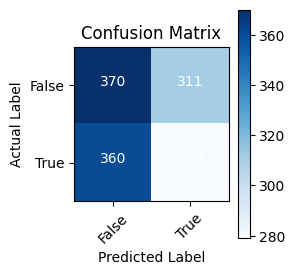

              precision    recall  f1-score   support

         0.0       0.51      0.54      0.52       681
         1.0       0.47      0.44      0.45       639

    accuracy                           0.49      1320
   macro avg       0.49      0.49      0.49      1320
weighted avg       0.49      0.49      0.49      1320



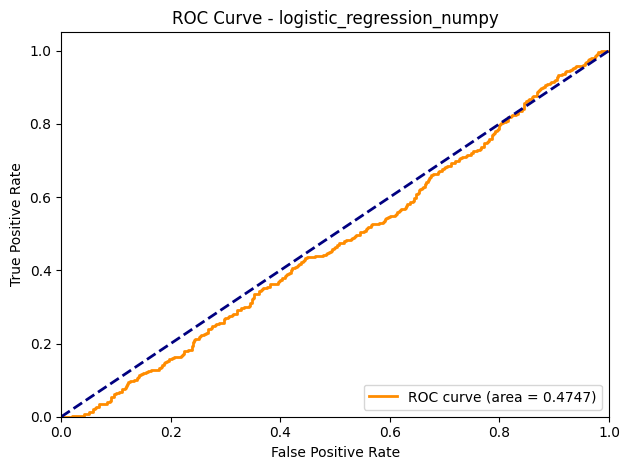

In [28]:
draw_confusion_matrix(clf_lr_2, x_test, y_test, 'logistic_regression_numpy')
draw_roc(clf_lr_2, x_test, y_test, 'logistic_regression_numpy')

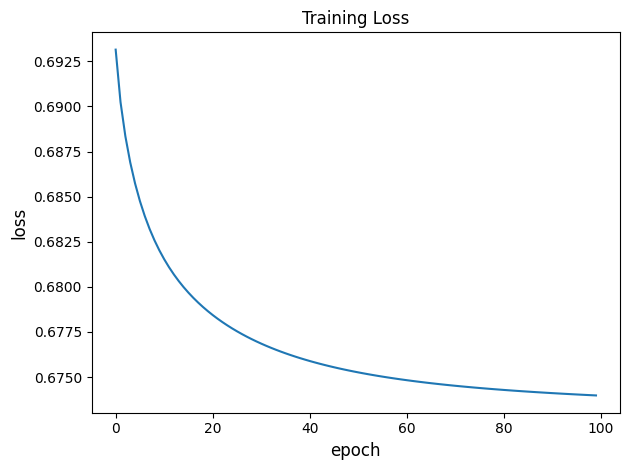

In [29]:
plt.figure()
plt.plot(history_lr)
plt.title('Training Loss')
plt.ylabel('loss', fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.tight_layout()
plt.savefig('lr_learning_curve.png', dpi=100, bbox_inches='tight')
plt.show()